In [2]:
from sqlalchemy import create_engine
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA  
import warnings
import itertools
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings("ignore")

# Load .env file
load_dotenv()

# Database credentials from .env
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create database connection
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

# Query all data for 5 banks and multiple years
query = """
SELECT s.bank_name, sp.date, sp.close_price, sp.high_price, sp.low_price, sp.open_price, sp.volume
FROM stock_prices as sp 
JOIN stocks as s ON s.ticker=sp.stock_ticker ;
"""
df = pd.read_sql(query, engine)

print(df.head())  
#converting data into the datetime format
df["date"] = pd.to_datetime(df["date"]) 
df.set_index("date", inplace=True)  # Set Date as index
# Moving averages periods
sma_period = 200  # 200-day SMA for long-term trends
ema_period = 100  # 100-day EMA for smoother trend tracking

# SMA & EMA computation for each bank
def compute_indicators(group):
    group["SMA"] = group["close_price"].rolling(window=sma_period).mean()
    group["EMA"] = group["close_price"].ewm(span=ema_period, adjust=False).mean()
    return group

df = df.groupby("bank_name", group_keys=False).apply(compute_indicators)
#daily returns calculations
df["Returns"] = np.log(df["close_price"] / df["close_price"].shift(1))

# Compute rolling volatility (30-day rolling std deviation of returns)
rolling_window = 30
df["Volatility"] = df["Returns"].rolling(window=rolling_window).std()
df


  bank_name        date  close_price  high_price  low_price  open_price  \
0       BMO  2020-01-03    80.279427   80.335287  79.593141   79.880423   
1       BMO  2020-01-06    80.215599   80.239544  79.856499   79.888420   
2       BMO  2020-01-07    80.079941   80.622585  80.048020   80.239546   
3       BMO  2020-01-08    80.662498   81.101398  80.199653   80.215611   
4       BMO  2020-01-09    80.957748   81.213110  80.702387   80.997651   

    volume  
0  1473000  
1  1147500  
2   702000  
3  1088400  
4  1683900  


,bank_name,close_price,high_price,low_price,open_price,volume,SMA,EMA,Returns,Volatility
date,,,,,,,,,,
2020-01-03,BMO,80.279427,80.335287,79.593141,79.880423,1473000,NaN,80.279427,NaN,NaN
2020-01-06,BMO,80.215599,80.239544,79.856499,79.888420,1147500,NaN,80.278163,-0.000795,NaN
2020-01-07,BMO,80.079941,80.622585,80.048020,80.239546,702000,NaN,80.274237,-0.001693,NaN
2020-01-08,BMO,80.662498,81.101398,80.199653,80.215611,1088400,NaN,80.281926,0.007248,NaN
2020-01-09,BMO,80.957748,81.213110,80.702387,80.997651,1683900,NaN,80.295308,0.003654,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-12-23,TD,74.591911,74.611639,73.733623,73.990124,5763300,76.807629,77.211308,0.007701,0.015508
2024-12-24,TD,75.193703,75.252892,74.483396,75.193703,1345700,76.796285,77.171356,0.008035,0.015474
2024-12-27,TD,75.391006,75.617913,75.075316,75.124645,5200200,76.786070,77.136101,0.002621,0.015471


ARIMA model
Steps to do:
1. Filter Data for One Bank 
2. Make Data Stationary – Use the Augmented Dickey-Fuller (ADF) test. If non-stationary, difference the data.
3. Select Best ARMA Parameters (p, q) – Use ACF/PACF plots.
4. Fit ARMA Model & Evaluate – Train the model and calculate errors.


In [3]:
# Dictionary to store DataFrames for each bank
bank_dfs = {}

# Get unique bank names
unique_banks = df["bank_name"].unique()

# Loop through each bank and create a DataFrame
for bank in unique_banks:
    bank_dfs[bank] = df[df["bank_name"] == bank].copy()

# Check the keys (bank names) to confirm
print("Created DataFrames for banks:", bank_dfs.keys())




Created DataFrames for banks: dict_keys(['BMO', 'CIBC', 'RBC', 'Scotiabank', 'TD'])


In [4]:
#data stationarity check

# Function to perform ADF test
def check_stationarity(series, bank_name):
    result = adfuller(series)
    print(f"Bank: {bank_name}")
    print("ADF Test Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] < 0.05:
        print("The series is stationary.\n")
    else:
        print("The series is NOT stationary. Differencing is needed.\n")

# Loop through each bank and check stationarity
for bank, df_bank in bank_dfs.items():
    check_stationarity(df_bank["close_price"], bank)

Bank: BMO
ADF Test Statistic: -1.0808899256178206
p-value: 0.7226323091203687
Critical Values: {'1%': -3.4356090875394525, '5%': -2.863862410805964, '10%': -2.568006480268158}
The series is NOT stationary. Differencing is needed.

Bank: CIBC
ADF Test Statistic: 0.1848518173383127
p-value: 0.9713990653157707
Critical Values: {'1%': -3.4356090875394525, '5%': -2.863862410805964, '10%': -2.568006480268158}
The series is NOT stationary. Differencing is needed.

Bank: RBC
ADF Test Statistic: 0.14131475608036106
p-value: 0.9687712418050584
Critical Values: {'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}
The series is NOT stationary. Differencing is needed.

Bank: Scotiabank
ADF Test Statistic: -0.7747843969373592
p-value: 0.8264169915769749
Critical Values: {'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}
The series is NOT stationary. Differencing is needed.

Bank: TD
ADF Test Statistic: -1.780673055203617
p-value: 0.390098

Because data is not statinary in case of all 5 banks, differencing is needed to remove trends.

In [5]:
#first-order differencing

for bank, df_bank in bank_dfs.items():
    df_bank["close_price_diff"] = df_bank["close_price"].diff().dropna()  
    print(f"\nChecking stationarity after differencing for {bank}:")
    check_stationarity(df_bank["close_price_diff"].dropna(), bank)



Checking stationarity after differencing for BMO:
Bank: BMO
ADF Test Statistic: -11.865247624699348
p-value: 6.699312274702034e-22
Critical Values: {'1%': -3.4356090875394525, '5%': -2.863862410805964, '10%': -2.568006480268158}
The series is stationary.


Checking stationarity after differencing for CIBC:
Bank: CIBC
ADF Test Statistic: -11.640620982752472
p-value: 2.151384409104341e-21
Critical Values: {'1%': -3.4356090875394525, '5%': -2.863862410805964, '10%': -2.568006480268158}
The series is stationary.


Checking stationarity after differencing for RBC:
Bank: RBC
ADF Test Statistic: -12.271857263076653
p-value: 8.604624733900337e-23
Critical Values: {'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}
The series is stationary.


Checking stationarity after differencing for Scotiabank:
Bank: Scotiabank
ADF Test Statistic: -11.661880196194033
p-value: 1.924646096975577e-21
Critical Values: {'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': 

After data become stationary, we can proceed with ARIMA modelling performing next steps: 
1. Identify p, d, q values (AutoRegression p, Differencing d, Moving Average q).
2. Use auto_arima() to find the best parameters (optional).
3. Fit ARIMA model for each bank.
4. Evaluate the model using residuals and AIC (Akaike Information Criterion).
5. Make predictions for future stock prices.


Processing ARIMA for BMO
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4380.125, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4388.065, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4387.640, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4387.600, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4387.512, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4379.534, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4389.492, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4377.559, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4379.531, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4389.575, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4376.940, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4386.927, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4386.964, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=4378.923, Time=0.18 sec
 ARIMA(

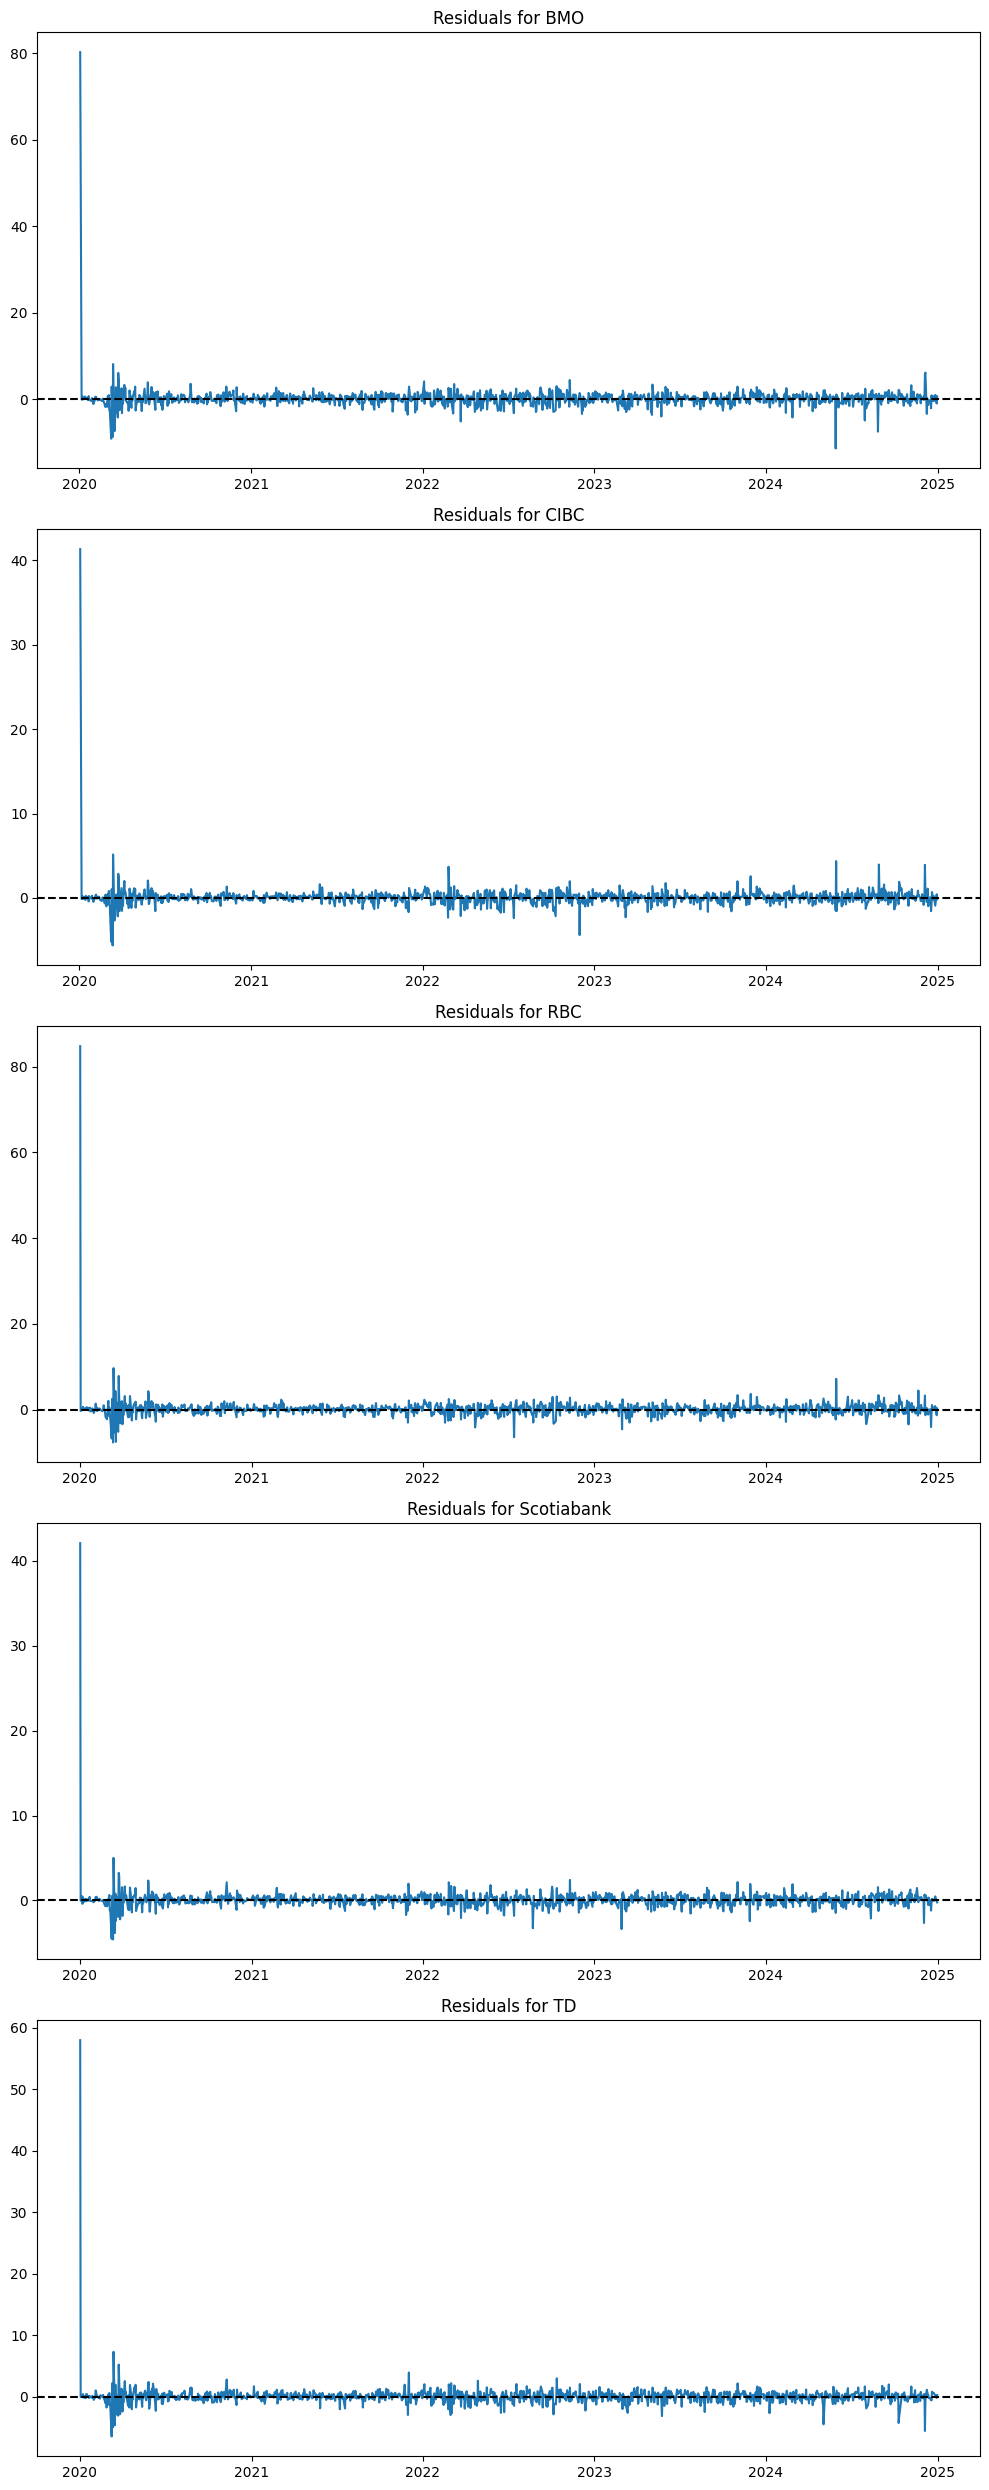

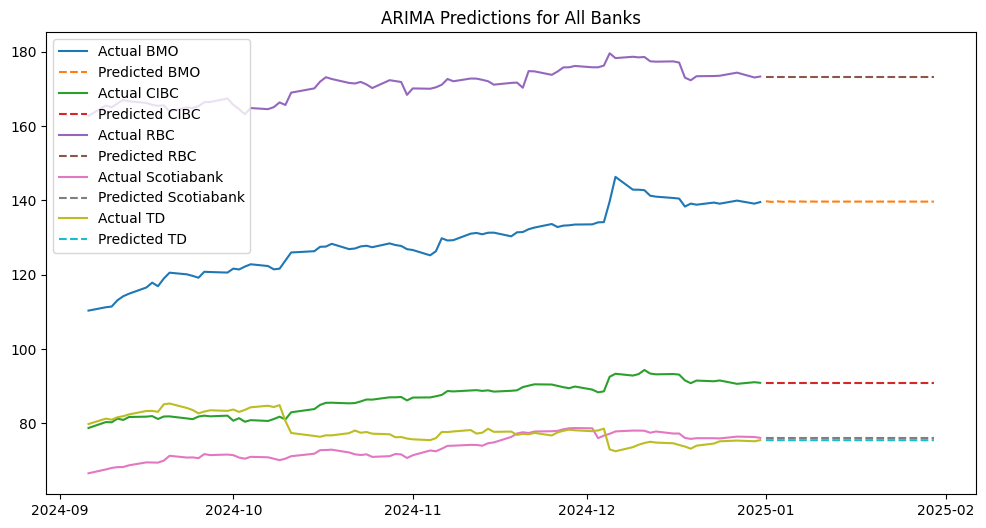

In [7]:
# Ignore warnings for clean output
warnings.filterwarnings("ignore")

# Dictionary to store ARIMA models and forecasts
arima_models = {}

# Dictionary to store residuals for each bank
residuals_dict = {}

# Dictionary to store predictions
predictions_dict = {}

# Loop through each bank to fit an ARIMA model
for bank, df_bank in bank_dfs.items():
    print(f"\nProcessing ARIMA for {bank}")

    # Ensure no NaN values after differencing
    df_bank = df_bank.dropna(subset=["close_price"])

    # Use auto_arima to find the best p, d, q values
    auto_arima_model = auto_arima(df_bank["close_price"], seasonal=False, trace=True)
    best_p, best_d, best_q = auto_arima_model.order
    print(f"Best ARIMA Order for {bank}: ({best_p}, {best_d}, {best_q})")

    # Fit the ARIMA model
    model = ARIMA(df_bank["close_price"], order=(best_p, best_d, best_q))
    arima_result = model.fit()

    # Store the fitted model
    arima_models[bank] = arima_result

    # Store residuals
    residuals_dict[bank] = arima_result.resid

    # Forecasting next 10 days
    forecast_steps = 30
    forecast = arima_result.forecast(steps=forecast_steps)
    predictions_dict[bank] = forecast

    print(f"\n Forecast for {bank} (next {forecast_steps} days):")
    print(forecast)


# Initialize lists to store evaluation results
mae_dict = {}
rmse_dict = {}

# Loop through each bank and calculate the evaluation metrics
for bank, df_bank in bank_dfs.items():
    # Get the actual values for comparison
    actual_values = df_bank["close_price"].iloc[-len(predictions_dict[bank]):]
    
    # Calculate MAE and RMSE for the forecast
    mae = mean_absolute_error(actual_values, predictions_dict[bank])
    rmse = np.sqrt(mean_squared_error(actual_values, predictions_dict[bank]))

    # Store the results
    mae_dict[bank] = mae
    rmse_dict[bank] = rmse

    # Print results for each bank
    print(f"\nMetrics for {bank}:")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")


# Plot residuals for all banks
fig, axes = plt.subplots(len(residuals_dict), 1, figsize=(10, 5 * len(residuals_dict)))
if len(residuals_dict) == 1:
    axes = [axes]  # Ensure axes is iterable for a single bank

for ax, (bank, residuals) in zip(axes, residuals_dict.items()):
    ax.plot(residuals)
    ax.set_title(f"Residuals for {bank}")
    ax.axhline(y=0, color="black", linestyle="dashed")

plt.tight_layout()
plt.show()

# Plot predictions for all banks
plt.figure(figsize=(12, 6))
# for bank, forecast in predictions_dict.items():
#     plt.plot(range(len(forecast)), forecast, linestyle="dashed", label=f"Predicted {bank}")
for bank, forecast in predictions_dict.items():
    # Get the actual data for the last 80 days
    actual_data = df[df["bank_name"] == bank].iloc[-80:]

    # Create a date range for the forecast period (next 30 days)
    last_date = actual_data.index[-1]
    forecast_dates = pd.date_range(start=last_date, periods=31, freq='D')[1:]  

    # Plot actual data
    plt.plot(actual_data.index, actual_data["close_price"], label=f"Actual {bank}")  

    # Plot forecast data
    plt.plot(forecast_dates, forecast, linestyle="dashed", label=f"Predicted {bank}")  


plt.title("ARIMA Predictions for All Banks")
plt.legend()
plt.show()


### MAE (Mean Absolute Error)
A lower MAE indicates better prediction accuracy. MAE measures the average magnitude of errors in a set of predictions, without considering their direction (i.e., overestimates or underestimates). It represents the average absolute difference between the predicted and actual values.

- **BMO (0.6309)**: On average, the model's predictions are off by 0.63 units from the actual values.
- **TD (0.9209)**: The predictions for TD are, on average, 0.92 units away from the actual values.

### RMSE (Root Mean Squared Error)
A lower RMSE value indicates better model accuracy, but RMSE is more sensitive to large errors due to the squaring of differences. RMSE penalizes large errors more than smaller ones. It calculates the square root of the average of the squared differences between the predicted and actual values. Since RMSE squares the errors, it gives more weight to larger discrepancies.

- **BMO (0.7317)**: The RMSE value is 0.73, which suggests the predictions for BMO are generally close to the actual values, with some penalty for larger errors.
- **RBC (1.8155)**: RBC's model has a higher RMSE, meaning its predictions are not only further from the actual values but also suffer from larger prediction errors compared to the others.

### Comparison Across Banks

#### Best Model (Lowest MAE and RMSE):
- **Scotiabank** has the lowest MAE (0.3550) and RMSE (0.5452), suggesting its ARIMA model is the most accurate and precise among the banks. The errors are consistently smaller, indicating better overall performance.

#### Worst Model (Highest MAE and RMSE):
- **RBC** shows the highest MAE (1.0860) and RMSE (1.8155), indicating that the model for RBC struggles more with prediction accuracy and has larger errors.

#### Other Banks:
- **BMO** and **Scotiabank**: Both show relatively lower errors. BMO's RMSE is 0.73, and Scotiabank's is 0.55, making them close in accuracy. Scotiabank, however, has a slightly better performance with lower MAE and RMSE.
- **CIBC** and **TD**: These have moderate errors. CIBC's MAE (0.7390) and RMSE (1.0901) suggest more noticeable prediction errors, while TD's MAE (0.9210) and RMSE (1.1716) show a similar performance but with slightly worse accuracy compared to CIBC.

### Interpretation:
- **Scotiabank** has the most accurate model (both in terms of MAE and RMSE), followed by **BMO**.
- **RBC** is performing the least well in terms of both MAE and RMSE.
- **CIBC** and **TD** are in between, with **CIBC** being slightly better.
